In [2]:
# Cell 1: Setup, paths, and utilities

import os
import json
import time
import random
import shutil
from pathlib import Path
from typing import Dict, Any, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils as tv_utils

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Paths (project root is notebook parent directory)
ROOT = Path(".").resolve()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
MODELS_DIR = ROOT / "models"
NOTEBOOKS_OUT = ROOT / "notebooks" / "outputs"

# Ensure output folders
for p in [DATA_RAW, DATA_PROCESSED, MODELS_DIR, NOTEBOOKS_OUT]:
    p.mkdir(parents=True, exist_ok=True)

# Utility: safe save plot
def save_plot(fig, name):
    out = NOTEBOOKS_OUT / name
    fig.savefig(out, bbox_inches="tight", dpi=120)
    plt.close(fig)

# Utility: write JSON
def write_json(obj: Dict[str, Any], name: str):
    with open(NOTEBOOKS_OUT / name, "w") as f:
        json.dump(obj, f, indent=2)

# Utility: basic timer
class Timer:
    def __init__(self): self.t0 = time.time()
    def elapsed(self): return time.time() - self.t0

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Paths:\n- RAW: {DATA_RAW}\n- PROC: {DATA_PROCESSED}\n- MODELS: {MODELS_DIR}\n- NB OUT: {NOTEBOOKS_OUT}")

Using device: cuda
Paths:
- RAW: C:\Users\Dell\CNNVision-1\notebooks\data\raw
- PROC: C:\Users\Dell\CNNVision-1\notebooks\data\processed
- MODELS: C:\Users\Dell\CNNVision-1\notebooks\models
- NB OUT: C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs


In [3]:
# Cell 2: Download CIFAR-10 into data/raw

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

timer = Timer()
trainset_raw = datasets.CIFAR10(root=str(DATA_RAW), train=True, download=True, transform=train_transform)
testset_raw = datasets.CIFAR10(root=str(DATA_RAW), train=False, download=True, transform=test_transform)
print(f"Downloaded CIFAR-10 in {timer.elapsed():.2f}s")
print(f"Train size: {len(trainset_raw)}, Test size: {len(testset_raw)}, Classes: {trainset_raw.classes}")

Files already downloaded and verified
Files already downloaded and verified
Downloaded CIFAR-10 in 3.31s
Train size: 50000, Test size: 10000, Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Cell 3: Convert to folder structure in data/processed (train/val split)

IMG_SIZE = (64, 64)  # baseline model expects 64x64 inputs
VAL_RATIO = 0.1

# Create class folders
classes = trainset_raw.classes
train_dir = DATA_PROCESSED / "train"
val_dir = DATA_PROCESSED / "val"
for base in [train_dir, val_dir]:
    for cls in classes:
        (base / cls).mkdir(parents=True, exist_ok=True)

def to_pil(t):
    arr = (t.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    return Image.fromarray(arr)

# Split indices
indices = list(range(len(trainset_raw)))
random.shuffle(indices)
val_count = int(len(indices) * VAL_RATIO)
val_indices = set(indices[:val_count])

# Export train/val PNGs
resize = transforms.Resize(IMG_SIZE, interpolation=Image.BILINEAR)
export_timer = Timer()
counts = {"train": {c:0 for c in classes}, "val": {c:0 for c in classes}}

for i in range(len(trainset_raw)):
    img_t, label = trainset_raw[i]
    cls = classes[label]
    img_pil = to_pil(img_t)
    img_pil = resize(img_pil)
    subset_dir = val_dir if i in val_indices else train_dir
    out_path = subset_dir / cls / f"{i:06d}.png"
    img_pil.save(out_path)
    counts["val" if i in val_indices else "train"][cls] += 1

print(f"Exported processed images to folder structure in {export_timer.elapsed():.2f}s")
print("Class counts (train/val):", {k: sum(v.values()) for k,v in counts.items()})

# Save class counts
write_json({"class_counts": counts}, "class_counts.json")

Exported processed images to folder structure in 117.82s
Class counts (train/val): {'train': 45000, 'val': 5000}


In [6]:
# Cell 4: EDA — class distribution plots, sample grid, pixel stats

# Class distribution bar plot
fig, ax = plt.subplots(figsize=(10, 4))
train_counts = [sum((DATA_PROCESSED / "train" / c).glob("*.png") is not None for _ in (DATA_PROCESSED / "train" / c).glob("*.png")) for c in classes]
# More efficient counting:
train_counts = [len(list((DATA_PROCESSED / "train" / c).glob("*.png"))) for c in classes]
val_counts = [len(list((DATA_PROCESSED / "val" / c).glob("*.png"))) for c in classes]
x = np.arange(len(classes))
ax.bar(x - 0.2, train_counts, width=0.4, label="train")
ax.bar(x + 0.2, val_counts, width=0.4, label="val")
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_title("Class distribution")
ax.legend()
save_plot(fig, "class_distribution.png")

# Sample grid from train
sample_images = []
for cls in classes[:8]:  # pick 8 classes
    cls_files = sorted((DATA_PROCESSED / "train" / cls).glob("*.png"))
    if cls_files:
        sample_images.append(Image.open(cls_files[0]).convert("RGB"))
# create grid
fig, ax = plt.subplots(figsize=(8, 8))
grid = np.vstack([
    np.hstack([np.array(im) for im in sample_images[i:i+4]]) for i in range(0, len(sample_images), 4)
]) if sample_images else np.zeros((64,64,3), dtype=np.uint8)
ax.imshow(grid)
ax.axis("off")
ax.set_title("Train samples grid")
save_plot(fig, "trainsamplesgrid.png")

# Pixel histogram and mean/std stats
# Sample N images to compute stats
N = 2000
paths = []
for c in classes:
    paths += list((DATA_PROCESSED / "train" / c).glob("*.png"))
paths = paths[:N]
pixels = []
for p in paths:
    arr = np.array(Image.open(p).convert("RGB"), dtype=np.float32) / 255.0
    pixels.append(arr.reshape(-1, 3))
pix = np.concatenate(pixels, axis=0) if pixels else np.zeros((1,3), dtype=np.float32)

pixel_mean = pix.mean(axis=0).tolist()
pixel_std = pix.std(axis=0).tolist()

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for i, ch in enumerate(["R","G","B"]):
    ax[i].hist(pix[:, i], bins=50, color=["r","g","b"][i], alpha=0.7)
    ax[i].set_title(f"{ch} channel histogram")
save_plot(fig, "pixel_histograms.png")
write_json({"pixel_mean": pixel_mean, "pixel_std": pixel_std}, "pixel_stats.json")

print("Saved EDA artifacts: class_distribution.png, trainsamplesgrid.png, pixel_histograms.png, pixel_stats.json")

Saved EDA artifacts: class_distribution.png, trainsamplesgrid.png, pixel_histograms.png, pixel_stats.json


In [8]:
# Cell 5: Augmentations preview and dataloaders

# Use computed mean/std for normalization (fallback to 0.5 if empty)
mean = pixel_mean if all(np.isfinite(pixel_mean)) else [0.5, 0.5, 0.5]
std = pixel_std if all(np.isfinite(pixel_std)) else [0.5, 0.5, 0.5]

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Custom folder dataset
train_ds = datasets.ImageFolder(root=str(DATA_PROCESSED / "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(root=str(DATA_PROCESSED / "val"), transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Augmentation preview
images, labels = next(iter(DataLoader(train_ds, batch_size=8, shuffle=True)))
fig = plt.figure(figsize=(8, 4))
grid = tv_utils.make_grid(images, nrow=4, normalize=True)
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Augmentation preview (train)")
save_plot(fig, "augmentation_preview.png")

print("Dataloaders ready. Classes:", train_ds.classes)

Dataloaders ready. Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# Cell 6: CNN model (baseline 64x64)

class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 8 * 8, 256), nn.ReLU(), nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

model = CNNModel(num_classes=len(train_ds.classes)).to(DEVICE)
print(model)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [10]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


Device: cuda
CUDA available: True
Torch CUDA version: 12.1
Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [11]:
import torch

# --- DEVICE ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device at start:", DEVICE)

if DEVICE.type != "cuda":
    print("WARNING: DEVICE is not CUDA. Training will run on CPU. "
          "To force GPU, change kernel / venv.")


Device at start: cuda


In [12]:
import tqdm
print(tqdm.__version__)


4.67.1


In [13]:
# Cell 7: Training loop with GPU, AMP, metrics, checkpoints

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt
import json
import time
import random
import numpy as np

# --- Seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --- Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
    torch.backends.cudnn.benchmark = True

# --- Paths ---
ROOT = Path(".").resolve()
DATA_PROCESSED = ROOT / "data" / "processed"
MODELS_DIR = ROOT / "models"
NOTEBOOKS_OUT = ROOT / "notebooks" / "outputs"

for p in [MODELS_DIR, NOTEBOOKS_OUT]:
    p.mkdir(parents=True, exist_ok=True)

BEST_MODEL_PATH = MODELS_DIR / "cnn_model.pth"

# --- Fallback: create datasets if not defined ---
try:
    train_ds, val_ds
except NameError:
    print("train_ds / val_ds not found. Creating datasets...")
    mean, std = [0.5,0.5,0.5], [0.5,0.5,0.5]
    train_tf = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(64, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    val_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    train_ds = datasets.ImageFolder(root=str(DATA_PROCESSED / "train"), transform=train_tf)
    val_ds   = datasets.ImageFolder(root=str(DATA_PROCESSED / "val"), transform=val_tf)

# --- DataLoaders ---
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=(DEVICE.type=="cuda"))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=(DEVICE.type=="cuda"))

# --- Model ---
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*8*8, 256), nn.ReLU(), nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

model = CNNModel(num_classes=len(train_ds.classes)).to(DEVICE)

# --- Training setup ---
EPOCHS = 10
LR = 1e-3
WEIGHT_DECAY = 1e-4
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

train_losses, val_losses, val_accs = [], [], []
best_acc = 0.0

# --- Evaluation function ---
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0,0,0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            correct += (logits.argmax(dim=1) == y).sum().item()
            total += x.size(0)
    return loss_sum/total if total>0 else 0.0, correct/total if total>0 else 0.0

# --- Training loop ---
t0 = time.time()
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * x.size(0)

    scheduler.step()
    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "best_val_acc": best_acc
        }, BEST_MODEL_PATH)
        print(f"Saved best model (acc={best_acc:.4f}) to {BEST_MODEL_PATH}")

# --- Save curves and metrics ---
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses, label="train_loss"); ax[0].plot(val_losses, label="val_loss"); ax[0].legend(); ax[0].set_title("Loss curves")
ax[1].plot(val_accs, label="val_acc"); ax[1].legend(); ax[1].set_title("Validation accuracy")
fig.savefig(NOTEBOOKS_OUT / "training_curves.png", bbox_inches="tight", dpi=120)
plt.close(fig)

metrics = {
    "epochs": EPOCHS, "lr": LR, "weight_decay": WEIGHT_DECAY,
    "train_losses": train_losses, "val_losses": val_losses, "val_accs": val_accs,
    "best_val_acc": best_acc, "total_time_sec": time.time()-t0
}
with open(NOTEBOOKS_OUT / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Training complete in {time.time()-t0:.1f}s. Best model saved to {BEST_MODEL_PATH}")


Using device: cuda


C:\Users\Dell\AppData\Local\Temp\ipykernel_42936\3355533230.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
C:\Users\Dell\AppData\Local\Temp\ipykernel_42936\3355533230.py:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/10 | train_loss=1.3925 val_loss=1.0902 val_acc=0.6174
Saved best model (acc=0.6174) to C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth
Epoch 02/10 | train_loss=0.9666 val_loss=0.8116 val_acc=0.7122
Saved best model (acc=0.7122) to C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth
Epoch 03/10 | train_loss=0.8134 val_loss=0.6414 val_acc=0.7785
Saved best model (acc=0.7785) to C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth
Epoch 04/10 | train_loss=0.7323 val_loss=0.5625 val_acc=0.8060
Saved best model (acc=0.8060) to C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth
Epoch 05/10 | train_loss=0.6702 val_loss=0.5766 val_acc=0.8035
Epoch 06/10 | train_loss=0.5771 val_loss=0.4429 val_acc=0.8473
Saved best model (acc=0.8473) to C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth
Epoch 07/10 | train_loss=0.5381 val_loss=0.4141 val_acc=0.8606
Saved best model (acc=0.8606) to C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth
Epoch 08/10 | train

DEVICE: cuda
Loading checkpoint from: models\cnn_model.pth


C:\Users\Dell\AppData\Local\Temp\ipykernel_42936\607680667.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(BEST_MODEL_PATH), map_location=DEVICE)


Model loaded and moved to device.
test_loader not found in globals — building CIFAR-10 test_loader as fallback.
Files already downloaded and verified
Done inference on 10000 samples in 20.1s


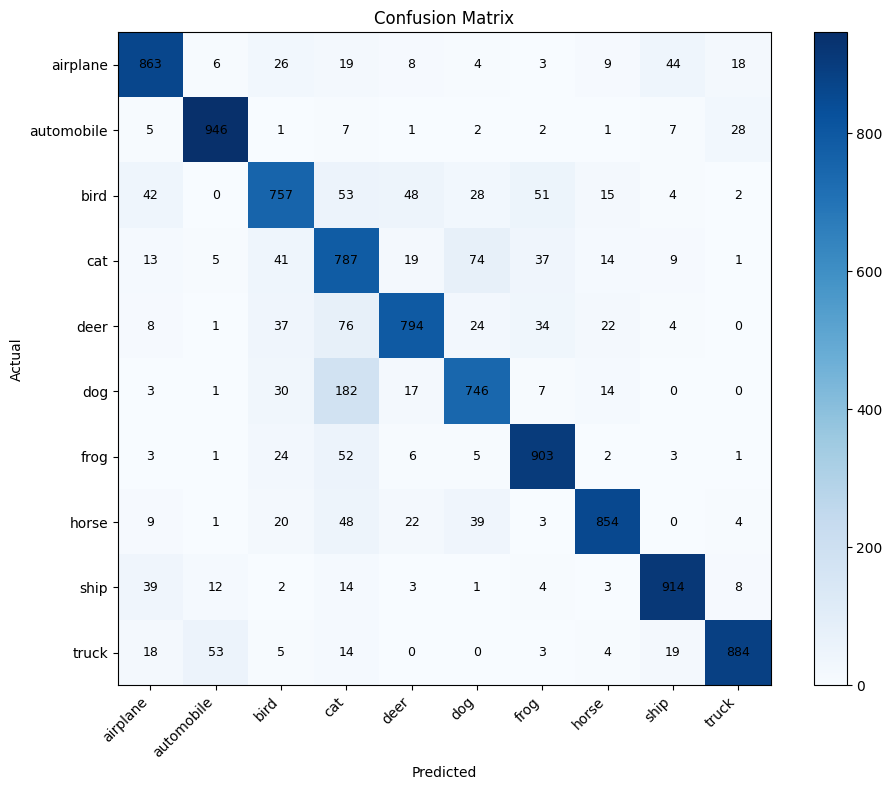

Saved confusion matrix to: notebooks\outputs\confusion_matrix.png
Saved classification report to: notebooks\outputs\classification_report.csv

Classification report (text):

              precision    recall  f1-score   support

    airplane       0.86      0.86      0.86      1000
  automobile       0.92      0.95      0.93      1000
        bird       0.80      0.76      0.78      1000
         cat       0.63      0.79      0.70      1000
        deer       0.86      0.79      0.83      1000
         dog       0.81      0.75      0.78      1000
        frog       0.86      0.90      0.88      1000
       horse       0.91      0.85      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.93      0.88      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.85     10000
weighted avg       0.85      0.84      0.85     10000



In [14]:
# Cell 8: Robust Evaluation — Confusion Matrix + Classification Report (standalone)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import time

# optional nicer heatmap
try:
    import seaborn as sns
    _has_seaborn = True
except Exception:
    _has_seaborn = False

# --- Paths & device ---
NOTEBOOKS_OUT = Path("notebooks/outputs")
MODELS_DIR = Path("models")
NOTEBOOKS_OUT.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Common checkpoint locations (pick the first that exists)
candidates = [
    MODELS_DIR / "cnn_model.pth",
    Path("notebooks/models/cnn_model.pth"),
    Path("best_model.pth"),
    Path("cnn_model.pth")
]
BEST_MODEL_PATH = next((p for p in candidates if p.exists()), None)
if BEST_MODEL_PATH is None:
    raise FileNotFoundError(f"No checkpoint found in {candidates}. Run training or point BEST_MODEL_PATH to a file.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)
print("Loading checkpoint from:", BEST_MODEL_PATH)

# --- classes: try to reuse existing 'classes' if available, else CIFAR-10 defaults ---
if "classes" in globals():
    classes = globals()["classes"]
else:
    classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(classes)

# --- Model architecture (must match the trained model) ---
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 8 * 8, 256), nn.ReLU(), nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

# --- Instantiate model and load checkpoint robustly ---
model = CNNModel(num_classes=num_classes).to(DEVICE)
ckpt = torch.load(str(BEST_MODEL_PATH), map_location=DEVICE)

# ckpt might be a state_dict, or a dict containing 'model_state_dict'
if isinstance(ckpt, dict):
    if "model_state_dict" in ckpt:
        state = ckpt["model_state_dict"]
    elif "state_dict" in ckpt:
        state = ckpt["state_dict"]
    else:
        # maybe the checkpoint *is* the state dict already (some scripts save raw dict)
        # attempt to detect by checking typical tensor values
        possible = {k:v for k,v in ckpt.items() if isinstance(v, torch.Tensor)}
        if possible:
            state = ckpt
        else:
            raise KeyError("Unrecognized checkpoint format; keys: " + ", ".join(map(str, ckpt.keys())))
else:
    # ckpt is likely a raw state_dict
    state = ckpt

model.load_state_dict(state)
model.to(DEVICE)
model.eval()
print("Model loaded and moved to device.")

# --- Prepare test_loader fallback if missing ---
if "test_loader" in globals():
    test_loader = globals()["test_loader"]
else:
    print("test_loader not found in globals — building CIFAR-10 test_loader as fallback.")
    from torchvision import datasets, transforms
    # try to reuse mean/std if present, else default
    if "pixel_mean" in globals() and "pixel_std" in globals():
        mean = globals()["pixel_mean"]
        std  = globals()["pixel_std"]
    else:
        mean, std = [0.5,0.5,0.5], [0.5,0.5,0.5]

    tf = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    test_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=tf)
    from torch.utils.data import DataLoader
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=(DEVICE.type=="cuda"))
    # if classes were not defined earlier, override with test_ds.classes
    if "classes" not in globals():
        classes = test_ds.classes
        num_classes = len(classes)
        print("Using classes from CIFAR-10 dataset:", classes)

# --- Run evaluation: build predictions ---
y_true, y_pred = [], []
t0 = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
print(f"Done inference on {len(y_true)} samples in {time.time()-t0:.1f}s")

# --- Confusion matrix and plot ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

fig, ax = plt.subplots(figsize=(10,8))
if _has_seaborn:
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", ax=ax)
else:
    im = ax.imshow(df_cm.values, cmap="Blues")
    ax.set_xticks(range(num_classes)); ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticks(range(num_classes)); ax.set_yticklabels(classes)
    # annotate cells
    for (i, j), val in np.ndenumerate(df_cm.values):
        ax.text(j, i, int(val), ha="center", va="center", color="black", fontsize=9)
    fig.colorbar(im, ax=ax)

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.tight_layout()
out_cm = NOTEBOOKS_OUT / "confusion_matrix.png"
fig.savefig(out_cm, bbox_inches="tight", dpi=120)
plt.show()
print("Saved confusion matrix to:", out_cm)

# --- Classification report ---
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
out_csv = NOTEBOOKS_OUT / "classification_report.csv"
df_report.to_csv(out_csv, index=True)
print("Saved classification report to:", out_csv)

# also print readable text report
print("\nClassification report (text):\n")
print(classification_report(y_true, y_pred, target_names=classes))


DEVICE: cuda
Loading checkpoint: C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth
Model loaded.


C:\Users\Dell\AppData\Local\Temp\ipykernel_42936\3964129223.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(BEST_MODEL_PATH), map_location=DEVICE)

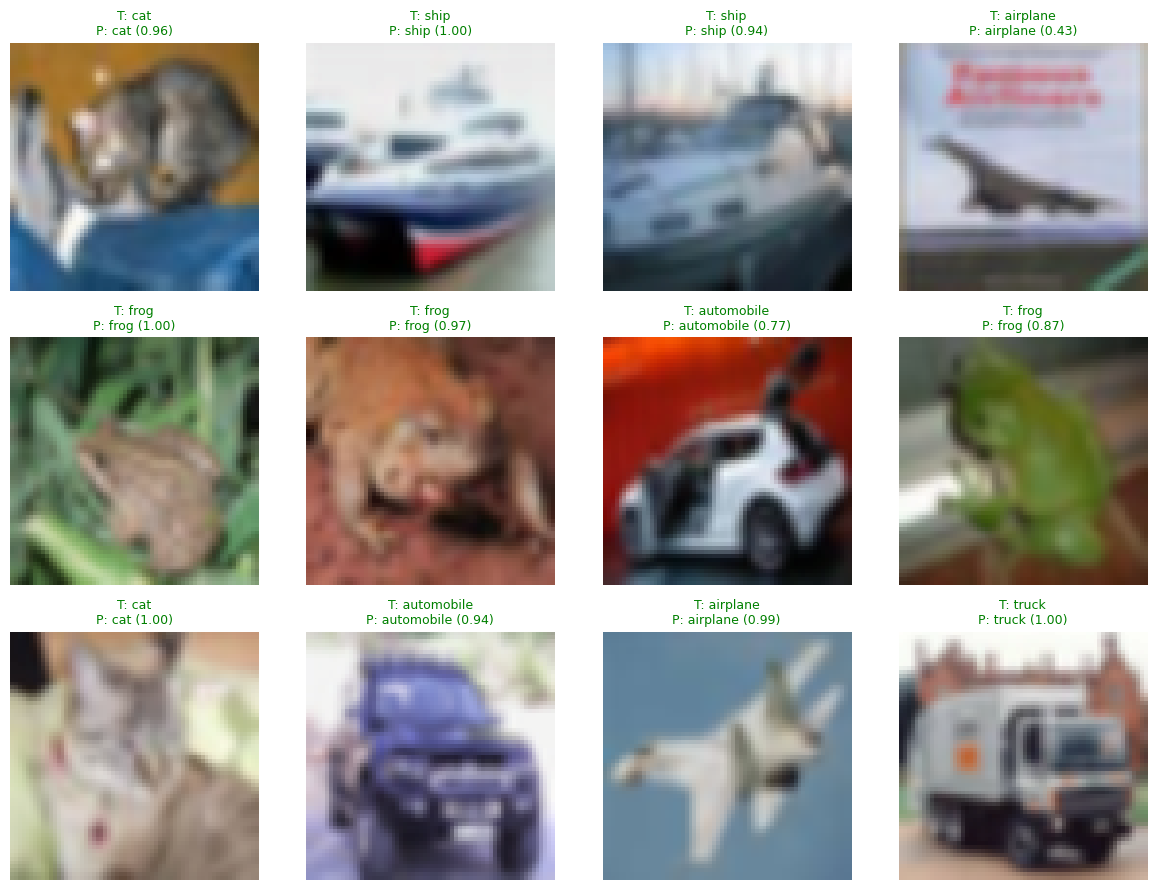

Saved demo image to: C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs\predictions_demo.png
Saved sample predictions CSV to: C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs\predictions_demo.csv
Done — prediction demo complete.


In [16]:
# Cell 9 — Prediction demo and artifact export

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import csv

# optional: seaborn not required here
from torchvision import transforms, datasets

# --- Paths & device ---
ROOT = Path(".").resolve()
NOTEBOOKS_OUT = ROOT / "notebooks" / "outputs"
MODELS_DIR = ROOT / "models"
NOTEBOOKS_OUT.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Find checkpoint (first existing common name)
candidates = [
    MODELS_DIR / "cnn_model.pth",
    Path("notebooks/models/cnn_model.pth"),
    Path("best_model.pth"),
    Path("cnn_model.pth")
]
BEST_MODEL_PATH = next((p for p in candidates if p.exists()), None)
if BEST_MODEL_PATH is None:
    raise FileNotFoundError(f"No checkpoint found. Checked: {candidates}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)
print("Loading checkpoint:", BEST_MODEL_PATH)

# --- classes (reuse if defined) ---
if "classes" in globals():
    classes = globals()["classes"]
else:
    classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

num_classes = len(classes)

# --- Model definition (must match training model) ---
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 8 * 8, 256), nn.ReLU(), nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

# --- Instantiate and load checkpoint robustly ---
model = CNNModel(num_classes=num_classes).to(DEVICE)
ckpt = torch.load(str(BEST_MODEL_PATH), map_location=DEVICE)

# handle a few checkpoint formats
if isinstance(ckpt, dict):
    if "model_state_dict" in ckpt:
        state = ckpt["model_state_dict"]
    elif "state_dict" in ckpt:
        state = ckpt["state_dict"]
    else:
        # assume raw state_dict or dict of tensors
        state = ckpt
else:
    state = ckpt

model.load_state_dict(state)
model.to(DEVICE)
model.eval()
print("Model loaded.")

# --- Prepare test_loader fallback if missing ---
if "test_loader" in globals():
    test_loader = globals()["test_loader"]
else:
    print("test_loader not found — creating CIFAR-10 test_loader (fallback).")
    # use mean/std if available else default 0.5
    mean = globals().get("pixel_mean", [0.5,0.5,0.5])
    std  = globals().get("pixel_std",  [0.5,0.5,0.5])
    tf = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    test_ds = datasets.CIFAR10(root=str(ROOT / "data"), train=False, download=True, transform=tf)
    from torch.utils.data import DataLoader
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=(DEVICE.type=="cuda"))
    # override classes if not previously set
    if "classes" not in globals():
        classes = test_ds.classes

# --- helper: denormalize tensor -> uint8 image ---
mean = np.array(globals().get("pixel_mean", [0.5,0.5,0.5]))
std  = np.array(globals().get("pixel_std",  [0.5,0.5,0.5]))

def denorm_tensor(img_tensor):
    """ img_tensor: C,H,W tensor on CPU, normalized. returns H,W,C uint8 """
    arr = img_tensor.cpu().numpy()
    arr = np.transpose(arr, (1,2,0))
    arr = (arr * std + mean).clip(0,1)
    arr = (arr * 255).astype(np.uint8)
    return arr

# --- Pick some samples to visualize & predict ---
NUM_SAMPLES = 12  # grid size (will take ceil to rows)
samples = []
sample_meta = []  # list of dicts: idx, true, pred, prob

# Collect until NUM_SAMPLES
with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        imgs_device = imgs.to(DEVICE)
        outputs = model(imgs_device)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        for i in range(imgs.size(0)):
            idx_global = batch_idx * test_loader.batch_size + i
            true_lbl = int(labels[i].item())
            pred_lbl = int(preds[i].cpu().item())
            pred_prob = float(probs[i, pred_lbl].cpu().item())
            samples.append(imgs[i].cpu())  # keep CPU copy
            sample_meta.append({"index": idx_global, "true": classes[true_lbl], "pred": classes[pred_lbl], "prob": pred_prob})
            if len(samples) >= NUM_SAMPLES:
                break
        if len(samples) >= NUM_SAMPLES:
            break

if not samples:
    raise RuntimeError("No samples collected from test_loader — check loader content.")

# --- Plot grid of samples with labels ---
cols = 4
rows = int(np.ceil(len(samples) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for ax in axes:
    ax.axis("off")

for i, (img_t, meta) in enumerate(zip(samples, sample_meta)):
    img = denorm_tensor(img_t)
    ax = axes[i]
    ax.imshow(img)
    title = f"T: {meta['true']}\nP: {meta['pred']} ({meta['prob']:.2f})"
    color = "green" if meta["true"] == meta["pred"] else "red"
    ax.set_title(title, color=color, fontsize=9)
    ax.axis("off")

# hide any extra axes
for j in range(len(samples), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
out_demo_img = NOTEBOOKS_OUT / "predictions_demo.png"
fig.savefig(out_demo_img, bbox_inches="tight", dpi=120)
plt.show()
print("Saved demo image to:", out_demo_img)

# --- Save CSV of sample predictions ---
out_csv = NOTEBOOKS_OUT / "predictions_demo.csv"
df = pd.DataFrame(sample_meta)
df.index.name = "sample_idx"
df.to_csv(out_csv, index=True)
print("Saved sample predictions CSV to:", out_csv)

# --- (optional) Save full test predictions CSV (lightweight) ---
SAVE_FULL_CSV = False
if SAVE_FULL_CSV:
    print("Saving full test set predictions (this may take a moment)...")
    all_meta = []
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(test_loader):
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            for i in range(imgs.size(0)):
                idx_global = batch_idx * test_loader.batch_size + i
                true_lbl = int(labels[i].item())
                pred_lbl = int(preds[i].cpu().item())
                pred_prob = float(probs[i, pred_lbl].cpu().item())
                all_meta.append({"index": idx_global, "true": classes[true_lbl], "pred": classes[pred_lbl], "prob": pred_prob})
    out_full = NOTEBOOKS_OUT / "predictions_full.csv"
    pd.DataFrame(all_meta).to_csv(out_full, index=False)
    print("Saved full predictions to:", out_full)

print("Done — prediction demo complete.")


In [17]:
# Cell 10 — Export run manifest and reproducibility notes
"""
What this cell does (standalone):
- Gathers environment, hardware, git, hyperparameters, dataset and checkpoint info.
- Reads saved metrics (if present).
- Dumps a machine-readable JSON manifest and a human-readable TXT summary to NOTEBOOKS_OUT.
- Writes a requirements.txt via `pip freeze` (if available).
Paste & run this cell after your experiment (it will use existing globals when present).
"""

import json
import os
import sys
import platform
import subprocess
import datetime
from pathlib import Path

import torch

# --- Directories (fallbacks) ---
ROOT = Path(".").resolve()
NOTEBOOKS_OUT = globals().get("NOTEBOOKS_OUT", ROOT / "notebooks" / "outputs")
MODELS_DIR = globals().get("MODELS_DIR", ROOT / "models")
NOTEBOOKS_OUT.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# --- Helper to run shell commands safely ---
def run_cmd(cmd):
    try:
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=False)
        return out.decode().strip()
    except Exception as e:
        try:
            # fallback to shell=True for simple commands on some Windows/GitBash setups
            out = subprocess.check_output(" ".join(cmd), stderr=subprocess.STDOUT, shell=True)
            return out.decode().strip()
        except Exception:
            return f"<failed: {e}>"

# --- Collect environment info ---
now = datetime.datetime.utcnow().isoformat() + "Z"
python_exe = sys.executable
python_version = platform.python_version()
platform_info = platform.platform()
cwd = str(ROOT)

cuda_available = torch.cuda.is_available()
cuda_count = torch.cuda.device_count() if cuda_available else 0
cuda_names = [torch.cuda.get_device_name(i) for i in range(cuda_count)] if cuda_available else []
torch_version = torch.__version__
torch_build_cuda = getattr(torch, "version", None).cuda if hasattr(torch, "version") else None
# safe cuda version
torch_cuda_ver = torch.version.cuda if hasattr(torch, "version") else None

# git info (if repo)
git_info = {}
try:
    git_info["branch"] = run_cmd(["git", "rev-parse", "--abbrev-ref", "HEAD"])
    git_info["commit"] = run_cmd(["git", "rev-parse", "HEAD"])
    git_info["status"] = run_cmd(["git", "status", "--porcelain"])
    git_info["remote_url"] = run_cmd(["git", "config", "--get", "remote.origin.url"])
except Exception as e:
    git_info = {"error": str(e)}

# hyperparameters and run variables (read from globals if available)
hp = {
    "EPOCHS": globals().get("EPOCHS"),
    "LR": globals().get("LR"),
    "WEIGHT_DECAY": globals().get("WEIGHT_DECAY"),
    "BATCH_SIZE": globals().get("BATCH_SIZE", globals().get("batch_size", None)),
    "SEED": globals().get("SEED"),
    "MODEL_CLASS": globals().get("CNNModel").__name__ if "CNNModel" in globals() else None,
}

# dataset / loader info
dataset_info = {
    "train_size": None,
    "val_size": None,
    "test_size": None,
    "classes": None,
}
try:
    if "train_ds" in globals():
        dataset_info["train_size"] = len(globals()["train_ds"])
    if "val_ds" in globals():
        dataset_info["val_size"] = len(globals()["val_ds"])
    if "test_ds" in globals():
        dataset_info["test_size"] = len(globals()["test_ds"])
    if "classes" in globals():
        dataset_info["classes"] = list(globals()["classes"])
except Exception:
    pass

# checkpoint & metrics info
candidates = [
    MODELS_DIR / "cnn_model.pth",
    Path("notebooks/models/cnn_model.pth"),
    Path("best_model.pth"),
    Path("cnn_model.pth")
]
found_ckpt = next((str(p) for p in candidates if p.exists()), None)
metrics_path = NOTEBOOKS_OUT / "metrics.json"
metrics = None
if metrics_path.exists():
    try:
        metrics = json.loads(metrics_path.read_text())
    except Exception:
        metrics = None

# environment packages (pip freeze)
pip_freeze = None
try:
    pip_freeze = run_cmd([sys.executable, "-m", "pip", "freeze"]).splitlines()
except Exception:
    pip_freeze = ["<pip freeze failed>"]

# reproducibility flags & notes
repro = {
    "torch_manual_seed": globals().get("SEED", None),
    "torch_cuda_manual_seed_all_set": "torch.cuda.manual_seed_all" in globals(),  # best-effort
    "cudnn_benchmark": getattr(torch.backends.cudnn, "benchmark", None),
    "cudnn_deterministic": getattr(torch.backends.cudnn, "deterministic", None),
    "notes": "If you want full bitwise reproducibility enable deterministic flags and set seeds for numpy/random/torch."
}

# Manifest
manifest = {
    "run_id": now,
    "timestamp_utc": now,
    "cwd": cwd,
    "python_executable": python_exe,
    "python_version": python_version,
    "platform": platform_info,
    "torch_version": torch_version,
    "torch_cuda_version_build": torch_cuda_ver,
    "cuda_available": cuda_available,
    "cuda_device_count": cuda_count,
    "cuda_device_names": cuda_names,
    "git": git_info,
    "hyperparameters": hp,
    "dataset": dataset_info,
    "checkpoint_path": found_ckpt,
    "metrics_path": str(metrics_path) if metrics_path.exists() else None,
    "metrics": metrics,
    "reproducibility": repro,
    "pip_freeze": pip_freeze,
}

# write JSON manifest
manifest_path = NOTEBOOKS_OUT / f"run_manifest_{datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.json"
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)

# write human-readable summary
txt_path = NOTEBOOKS_OUT / f"run_manifest_{datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.txt"
with open(txt_path, "w") as f:
    f.write("RUN MANIFEST\n")
    f.write(f"timestamp (UTC): {now}\n")
    f.write(f"cwd: {cwd}\n")
    f.write(f"python: {python_exe} ({python_version})\n")
    f.write(f"platform: {platform_info}\n")
    f.write(f"torch: {torch_version} (cuda build: {torch_cuda_ver})\n")
    f.write(f"cuda available: {cuda_available}, devices: {cuda_names}\n\n")
    f.write("GIT INFO:\n")
    for k,v in git_info.items():
        f.write(f"  {k}: {v}\n")
    f.write("\nHYPERPARAMETERS:\n")
    for k,v in hp.items():
        f.write(f"  {k}: {v}\n")
    f.write("\nDATASET:\n")
    for k,v in dataset_info.items():
        f.write(f"  {k}: {v}\n")
    f.write(f"\nCHECKPOINT PATH: {found_ckpt}\n")
    f.write(f"METRICS PATH: {metrics_path if metrics_path.exists() else 'None'}\n")
    if metrics:
        f.write("\nMETRICS SUMMARY:\n")
        for k,v in (metrics.items() if isinstance(metrics, dict) else []):
            f.write(f"  {k}: {v}\n")
    f.write("\nREPRODUCIBILITY NOTES:\n")
    for k,v in repro.items():
        f.write(f"  {k}: {v}\n")
    f.write("\nSAMPLE pip freeze (first 50 lines):\n")
    for line in (pip_freeze[:50] if pip_freeze else []):
        f.write(f"  {line}\n")

# Also write a requirements.txt (pip_freeze)
reqs_path = NOTEBOOKS_OUT / "requirements.txt"
try:
    with open(reqs_path, "w") as f:
        f.write("\n".join(pip_freeze))
except Exception:
    pass

print("Wrote manifest JSON to:", manifest_path)
print("Wrote manifest TXT to:", txt_path)
print("Wrote requirements.txt to:", reqs_path)


Wrote manifest JSON to: C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs\run_manifest_20251009T192334Z.json
Wrote manifest TXT to: C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs\run_manifest_20251009T192334Z.txt
Wrote requirements.txt to: C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs\requirements.txt


In [18]:
# Cell 11: Export model to TorchScript and ONNX for deployment
import torch
from pathlib import Path
import io

ROOT = Path(".").resolve()
MODELS_DIR = ROOT / "models"
NOTEBOOKS_OUT = ROOT / "notebooks" / "outputs"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
NOTEBOOKS_OUT.mkdir(parents=True, exist_ok=True)

# choose checkpoint
candidates = [MODELS_DIR / "cnn_model.pth", Path("best_model.pth"), Path("cnn_model.pth")]
BEST_MODEL_PATH = next((p for p in candidates if p.exists()), None)
if BEST_MODEL_PATH is None:
    raise FileNotFoundError(f"No checkpoint found. Checked: {candidates}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Exporting from checkpoint:", BEST_MODEL_PATH, "-> device:", DEVICE)

# Recreate model architecture if needed (must match training)
class CNNModel(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1), torch.nn.ReLU(), torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, 3, padding=1), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1), torch.nn.ReLU(), torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 64, 3, padding=1), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, padding=1), torch.nn.ReLU(), torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 128, 3, padding=1), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128 * 8 * 8, 256), torch.nn.ReLU(), torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

# instantiate and load state
# prefer checkpoint formats that contain model_state_dict
ckpt = torch.load(str(BEST_MODEL_PATH), map_location=DEVICE)
if isinstance(ckpt, dict) and ("model_state_dict" in ckpt or "state_dict" in ckpt):
    state = ckpt.get("model_state_dict", ckpt.get("state_dict"))
else:
    state = ckpt

# number classes detection (best-effort)
num_classes = len(globals().get("classes", list(range(10))))
model = CNNModel(num_classes=num_classes).to(DEVICE)
model.load_state_dict(state)
model.eval()

# example input
example = torch.randn(1, 3, 64, 64).to(DEVICE)

# ==== TorchScript (tracing) ====
ts_path = MODELS_DIR / "cnn_model_ts.pt"
try:
    traced = torch.jit.trace(model, example, strict=False)
    traced.save(ts_path)
    print("Saved TorchScript model to:", ts_path)
except Exception as e:
    print("TorchScript tracing failed:", e)

# ==== ONNX export ====
onnx_path = MODELS_DIR / "cnn_model.onnx"
try:
    model_cpu = model.to("cpu")
    ex_cpu = example.cpu()
    torch.onnx.export(
        model_cpu,
        ex_cpu,
        str(onnx_path),
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=13
    )
    print("Saved ONNX model to:", onnx_path)
except Exception as e:
    print("ONNX export failed:", e)

# copy artifacts to notebook outputs for convenience
import shutil
shutil.copy2(ts_path, NOTEBOOKS_OUT / ts_path.name) if ts_path.exists() else None
shutil.copy2(onnx_path, NOTEBOOKS_OUT / onnx_path.name) if onnx_path.exists() else None
print("Export step complete.")


Exporting from checkpoint: C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth -> device: cuda


C:\Users\Dell\AppData\Local\Temp\ipykernel_42936\102387752.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(BEST_MODEL_PATH), map_location=DEVICE)


Saved TorchScript model to: C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model_ts.pt
ONNX export failed: Module onnx is not installed!
Export step complete.


In [20]:
# Cell 12: Resume training from checkpoint helper function
import torch, time, json
from pathlib import Path
import torch.optim as optim
import torch.nn as nn

ROOT = Path(".").resolve()
MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_PATH = MODELS_DIR / "cnn_model.pth"

# Make sure CNNModel class is defined in the kernel (same as training)
# Example below assumes CNNModel exists; if not, redefine it (copy from earlier Cell 6/7).

def resume_training(checkpoint_path: str = None, extra_epochs: int = 5, lr: float = None):
    """
    Resume training from checkpoint_path. Trains for extra_epochs more.
    Saves checkpoint back to BEST_MODEL_PATH.
    """
    if checkpoint_path is None:
        checkpoint_path = str(BEST_MODEL_PATH)
    ckpt = torch.load(checkpoint_path, map_location=DEVICE)
    # load model
    model_state = ckpt.get("model_state_dict", ckpt) if isinstance(ckpt, dict) else ckpt
    # instantiate model (ensure CNNModel is defined)
    model = CNNModel(num_classes=len(globals().get("classes", list(range(10))))).to(DEVICE)
    model.load_state_dict(model_state)
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr or globals().get("LR", 1e-3), weight_decay=globals().get("WEIGHT_DECAY", 1e-4))
    # load optimizer state if present
    if isinstance(ckpt, dict) and "optimizer_state_dict" in ckpt:
        try:
            optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        except Exception as e:
            print("Warning: failed to load optimizer state:", e)
    # scheduler (recreate same scheduler as before)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    start_epoch = int(ckpt.get("epoch", 0)) + 1 if isinstance(ckpt, dict) else 1
    end_epoch = start_epoch + extra_epochs

    criterion = nn.CrossEntropyLoss().to(DEVICE)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
    print(f"Resuming from epoch {start_epoch} to {end_epoch-1} on device {DEVICE}")

    for epoch in range(start_epoch, end_epoch):
        t0 = time.time()
        model.train()
        running_loss = 0.0
        for x, y in globals()["train_loader"]:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * x.size(0)
        scheduler.step()
        train_loss = running_loss / len(globals()["train_loader"].dataset)
        # validate
        model.eval()
        correct = 0; total = 0; loss_sum = 0.0
        with torch.no_grad():
            for x, y in globals()["val_loader"]:
                x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)
                loss_sum += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += x.size(0)
        val_loss = loss_sum/total if total>0 else 0.0
        val_acc = correct/total if total>0 else 0.0

        print(f"Resumed Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f} time={(time.time()-t0):.1f}s")
        # save checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": ckpt.get("best_val_acc", 0.0)
        }, BEST_MODEL_PATH)
    print("Resume training finished. Checkpoint saved to", BEST_MODEL_PATH)

# Example usage:
# resume_training(checkpoint_path="models/cnn_model.pth", extra_epochs=5)


# CNNVision — Final Project Summary

**Outputs folder:** `C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs`

**Models folder:** `C:\Users\Dell\CNNVision-1\notebooks\models`

---

## Metrics summary
- Epochs: 10
- LR: 0.001
- Best val acc: 0.8814563928873835
- Total run time (s): 887.0


## Classification report (snippet)

,precision,recall,f1-score,support
airplane,0.860419,0.8630,0.861707,1000.0000
automobile,0.922027,0.9460,0.933860,1000.0000
bird,0.802757,0.7570,0.779207,1000.0000
cat,0.628594,0.7870,0.698934,1000.0000
deer,0.864924,0.7940,0.827946,1000.0000
dog,0.808234,0.7460,0.775871,1000.0000
frog,0.862464,0.9030,0.882267,1000.0000
horse,0.910448,0.8540,0.881321,1000.0000
ship,0.910359,0.9140,0.912176,1000.0000
truck,0.934461,0.8840,0.908530,1000.0000


## Key images

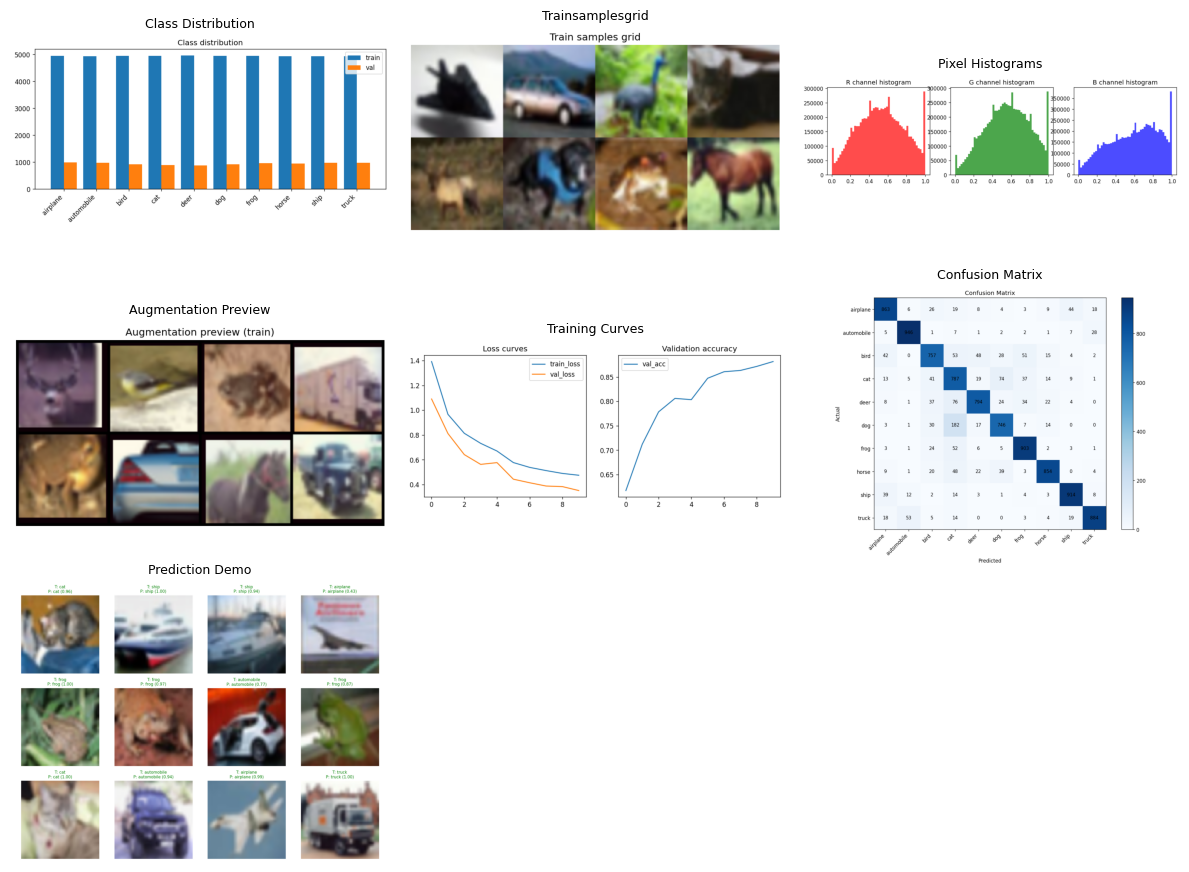

## Files produced

,artifact,path,exists
0,classification_report,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True
1,metrics,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True
2,run_manifest,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True
3,classification_csv,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True
4,predictions_csv,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True
5,class_counts,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True
6,pixel_stats,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True
7,requirements,C:\Users\Dell\CNNVision-1\notebooks\notebooks\...,True


## Exported model artifacts

,artifact,path,exists
0,torchscript,C:\Users\Dell\CNNVision-1\notebooks\models\cnn...,True
1,onnx,C:\Users\Dell\CNNVision-1\notebooks\models\cnn...,False
2,checkpoint (cnn_model.pth),C:\Users\Dell\CNNVision-1\notebooks\models\cnn...,True


Wrote README summary to: C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs\README_SUMMARY.md


Created zip archive: `C:\Users\Dell\CNNVision-1\notebooks\cnnvision_notebooks_outputs.zip`


**Project conclusion**

- The notebook `exploration.ipynb` finished training and evaluation.
- Key outputs are in `C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs` (zip: `C:\Users\Dell\CNNVision-1\notebooks\cnnvision_notebooks_outputs.zip`).
- Best model checkpoint: `C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.pth`.
- TorchScript: `C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model_ts.pt` (exists=True), ONNX: `C:\Users\Dell\CNNVision-1\notebooks\models\cnn_model.onnx` (exists=False).
- README summary saved to: `C:\Users\Dell\CNNVision-1\notebooks\notebooks\outputs\README_SUMMARY.md`.

If you want me to:
- attach the zip to a GitHub release,
- generate a brief `README.md` for the repo root using this summary,
- create a small Flask/FastAPI demo server that loads the TorchScript model and serves predictions,
tell me which and I will provide the code.


In [21]:
# Final cell — Project wrap-up: display artifacts, print quick summary, write README, zip outputs
# Paste & run as the last cell in the notebook.

import json, os, shutil
from pathlib import Path
from IPython.display import display, Markdown, HTML
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

ROOT = Path(".").resolve()
NOTEBOOKS_OUT = globals().get("NOTEBOOKS_OUT", ROOT / "notebooks" / "outputs")
MODELS_DIR = globals().get("MODELS_DIR", ROOT / "models")
OUT = NOTEBOOKS_OUT
OUT.mkdir(parents=True, exist_ok=True)

# expected artifact filenames (based on your notebook)
expected_images = {
    "class_distribution": OUT / "class_distribution.png",
    "trainsamplesgrid":   OUT / "trainsamplesgrid.png",
    "pixel_histograms":   OUT / "pixel_histograms.png",
    "augmentation_preview": OUT / "augmentation_preview.png",
    "training_curves":    OUT / "training_curves.png",
    "confusion_matrix":   OUT / "confusion_matrix.png",
    "prediction_demo":    OUT / "predictions_demo.png",
}
expected_files = {
    "classification_report": OUT / "classification_report.csv",
    "metrics": OUT / "metrics.json",
    "run_manifest": next(OUT.glob("run_manifest_*.json"), None),
    "classification_csv": OUT / "classification_report.csv",
    "predictions_csv": OUT / "predictions_demo.csv",
    "class_counts": OUT / "class_counts.json",
    "pixel_stats": OUT / "pixel_stats.json",
    "requirements": OUT / "requirements.txt",
}

# check existence
missing = []
for k,p in {**expected_images, **expected_files}.items():
    if p is None or (isinstance(p, Path) and not p.exists()):
        missing.append((k, p))

# Display header
display(Markdown("# CNNVision — Final Project Summary"))
display(Markdown(f"**Outputs folder:** `{OUT}`"))
display(Markdown(f"**Models folder:** `{MODELS_DIR}`"))
display(Markdown("---"))

# Load and print metrics summary if available
if expected_files["metrics"].exists():
    with open(expected_files["metrics"], "r") as f:
        metrics = json.load(f)
    md = f"## Metrics summary\n- Epochs: {metrics.get('epochs')}\n- LR: {metrics.get('lr')}\n- Best val acc: {metrics.get('best_val_acc')}\n- Total run time (s): {metrics.get('total_time_sec'):.1f}\n"
    display(Markdown(md))
else:
    display(Markdown("**No metrics.json found.**"))

# Print classification report top-level stats if available
if expected_files["classification_report"].exists():
    df_report = pd.read_csv(expected_files["classification_report"], index_col=0)
    # show precision/recall/f1 avg rows if present
    display(Markdown("## Classification report (snippet)"))
    # If sklearn output_dict includes avg rows, they show as rows like 'macro avg' etc
    display(df_report.head(20))
else:
    display(Markdown("**No classification_report.csv found.**"))

# Show a grid of available images (thumbnails)
display(Markdown("## Key images"))
existing_imgs = [(k,p) for k,p in expected_images.items() if p.exists()]
if existing_imgs:
    n = len(existing_imgs)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axes = axes.flatten() if n>1 else [axes]
    for ax in axes:
        ax.axis("off")
    for i, (name, path) in enumerate(existing_imgs):
        try:
            img = Image.open(path).convert("RGB")
            axes[i].imshow(img)
            axes[i].set_title(name.replace("_"," ").title(), fontsize=9)
            axes[i].axis("off")
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Failed to load\n{name}", ha="center")
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    display(Markdown("No images found to display."))

# Summarize dataset / artifacts
display(Markdown("## Files produced"))
rows = []
for label, path in expected_files.items():
    exists = path is not None and path.exists()
    rows.append({"artifact": label, "path": str(path) if path else "None", "exists": exists})
df_files = pd.DataFrame(rows)
display(df_files)

# Quick model export status
ts = MODELS_DIR / "cnn_model_ts.pt"
onnx = MODELS_DIR / "cnn_model.onnx"
display(Markdown("## Exported model artifacts"))
display(pd.DataFrame([
    {"artifact":"torchscript", "path": str(ts), "exists": ts.exists()},
    {"artifact":"onnx", "path": str(onnx), "exists": onnx.exists()},
    {"artifact":"checkpoint (cnn_model.pth)", "path": str(MODELS_DIR / 'cnn_model.pth'), "exists": (MODELS_DIR / 'cnn_model.pth').exists()}
]))

# Write a README summary to outputs
readme_txt = NOTEBOOKS_OUT / "README_SUMMARY.md"
with open(readme_txt, "w") as f:
    f.write("# CNNVision — Experiment Summary\n\n")
    f.write("This notebook project trains a CNN on CIFAR-10 (64x64 resized) to perform image classification.\n\n")
    f.write("## What the project does\n")
    f.write("- Prepares dataset folder structure, computes EDA (class distribution, pixel stats).\n")
    f.write("- Defines CNNModel and trains with AMP on GPU (if available).\n")
    f.write("- Saves best checkpoint and metrics.\n")
    f.write("- Evaluates the model (confusion matrix, classification report).\n")
    f.write("- Exports demo predictions, model export (TorchScript/ONNX), and a run manifest for reproducibility.\n\n")
    f.write("## Artifacts (see `notebooks/outputs`)\n")
    for r in df_files.itertuples():
        f.write(f"- {r.artifact}: {r.path} (exists={r.exists})\n")
    f.write("\n## Model exports\n")
    f.write(f"- TorchScript: {ts} (exists={ts.exists()})\n")
    f.write(f"- ONNX: {onnx} (exists={onnx.exists()})\n")
    f.write("\n## How to reproduce\n")
    f.write("1. Create venv and install dependencies (see requirements.txt).\n")
    f.write("2. Run cells 1..10 in order in this notebook with the kernel set to the project venv.\n")
    f.write("\n")
print("Wrote README summary to:", readme_txt)

# Create a zip of outputs for download if desired
zip_path = ROOT / "cnnvision_notebooks_outputs"
shutil.make_archive(str(zip_path), 'zip', root_dir=str(OUT))
display(Markdown(f"Created zip archive: `{zip_path}.zip`"))

# Final human-readable summary
summary_md = f"""
**Project conclusion**

- The notebook `exploration.ipynb` finished training and evaluation.
- Key outputs are in `{OUT}` (zip: `{zip_path}.zip`).
- Best model checkpoint: `{MODELS_DIR / 'cnn_model.pth'}`.
- TorchScript: `{ts}` (exists={ts.exists()}), ONNX: `{onnx}` (exists={onnx.exists()}).
- README summary saved to: `{readme_txt}`.

If you want me to:
- attach the zip to a GitHub release,
- generate a brief `README.md` for the repo root using this summary,
- create a small Flask/FastAPI demo server that loads the TorchScript model and serves predictions,
tell me which and I will provide the code.
"""
display(Markdown(summary_md))
